CNN으로 패션아이템 구분하기

2022년 1월 6일 
김이룸

똑같은 필터를 쓰면 결과가 다같다.
필터가 다르면 결과도 다르다.
그래서 필터가 굉장히 중요함.

In [ ]:
# 1번 셀

# 패키지 수입
# 자동완성은 런 한번하고 서버 연결이 되야 그 후부터 작동한다.
import matplotlib.pyplot as plt
import numpy as np
from time import time

from keras.datasets import fashion_mnist # keras가 공유하는 데이터
from keras.models import Sequential # 인공신경망을 만들 적에 '순차적'으로 필요한 충들을 add하는 모델
from keras.utils import np_utils # 출력데이터 처리 : 1-hot incoding

from keras.layers import Dense # fully-connected layer -> dense
from keras.layers import Flatten, Conv2D, MaxPool2D # convolution 2d 
from keras.layers import InputLayer # 입력층



In [ ]:
# 2번 셀

# 하이퍼 파라미터

MY_EPOCH = 10 # 반복학습 수
MY_BATCH = 500 # 매번 가져와서 계산하는 학습용 데이터 수 -> 6만개에서 my_batch만큼 sample을 처리하고 모든 학습데이터로 학습 할 때까지 한번에 마이배치만큼 학습시킴
# 한 배치당 한번 가중치 보정이 일어난다.
# BATCH란 무엇인가? 답 : 판서를 참고하라.
# 학습용 데이터 육만개
# CNN만들면 입력 주고 출력나온다.
# 샘플 하나가 이미지 한개다.
# 육만개를 동시에 불러와서 cnn으로 보내지 않는다.
# 버겁다 . 그래서 육만개 중 오백개씩 갖고와서 학습해서 cnn으로 보내고
# 6만개 다 학습할 때까지 오백개씩 끊어서 cnn으로 배달한다. -> 그럼 총 120번 배달하는건가?
# 배치사이즈는 너무 커도 안좋고 너무 작아도안좋다.
# 배치가 너무 크면 왜 안좋은가? 답 : 한번에 처리해야할 양이 너무 많다. 잘못하면 gpu 죽는다. gpu 낭비다.
# 배치가 너무 작으면 왜 안좋은가? 답 : 학습시간이 너무 오래걸린다. 배치가 2이면 배달을 3만번 해야한다.
# 배치사이즈는 무엇을 기준으로 결정한다? 답 : 본인 컴퓨터 사양에 맞게 결정한다.
# 하이퍼 파라메터 튜니이란 값이 바꿔보는 것을 의미한다. 튜닝은 학습시간과 mse에 영향을 미친다.

학습용 입력 데이터 모양 :  (60000, 28, 28)
학습용 출력 데이터 모양 :  (60000,)
평가용 입력 데이터 모양 :  (10000, 28, 28)
평가용 출력 데이터 모양 :  (10000,)
(28, 28)
0번 학습용 이미지 라벨 :  9


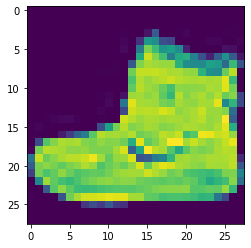

In [ ]:
# 3번 셀

# 데이터 불러오기
# 자르고 나누고 안해도 된다. 케라스가 다 해놓음.
# 순서 주의해라

(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data() # 데이터 4분할 -> raw 보기 전에 바로 split 해버리네? 
# 케라스가 만들어 놓은 것 다운로드 받으면 끝이다.
# 데이터 불러오면 모양부터 확인해라. 습관을 들여라. 특히 딥러닝할 때 반드시 필요함.

# 데이터 모양확인
# print('학습용 입력 데이터 모양 : ', X_train.shape)
# 3차원 데이터
# 육만은 이미지 개수
# 두번째 28은 x축의 화소수
# 28은 y축의 화소수
# print('학습용 출력 데이터 모양 : ', Y_train.shape)
# print(X_train[0]) # 이게 첫번 째 사진 784 화소 데이터이다. 각각의 화소가 나타난 것 -> 화소값 나오는 행이다.
# 각각의 화소는 0부터 255까지의 범위를 갖는 정수값이다
# 0은 검은색 255는 하얀색, 100은 회색이다.
# 이는 몇비트 데이터인가? 255를 이진수로 전환하면 몇자리가 되는가? 답 : 8자리가 필요하다. 따라서 gray_scale은 8bit 데이터이다.
# 흑백사진이건 칼라사진이건 비트수를 봐야한다????
# 이진수 관련 판서를 참고하라. ex) 255 -> 11111111 -> 8bit image data
# 각화소는 0에서 255 사이의 정수값을 갖는다.

plt.imshow(X_train[0]) # ankle boot 이미지가 나온다.'
# 위 팔레트를 바꿔보자
# plt.imshow(X_train[0], cmap='gray') # 이건 채널 하나다.

# 칼라이미지는 채널 3개가 더 추가가된다.
# print('0번 학습용 이미지 라벨 : ', Y_train[0]) # y_train하면 육만개 나온다. 0번지 라벨만 봐보자.
# 9. 답은 숫자로 나온다. 그럼 9가 뭔가? 답 : ankle boots이다. mnist 패션 데이터 슬라이드 레전드 보면 부츠의 라벨이 9다.

# lim's comment : 수치 데이터는 8-bit 화소 정수 [0,255]


print('학습용 입력 데이터 모양 : ', X_train.shape) 
print('학습용 출력 데이터 모양 : ', Y_train.shape) # 라벨은 1차원 데이터다. 그래서 (60000,)
print('평가용 입력 데이터 모양 : ', X_test.shape) # 
print('평가용 출력 데이터 모양 : ', Y_test.shape) # 실행 전 예측해봐라.
# 평가용 데이터는 10000개가 있다.
print(X_train[0].shape) # 2차원 데이터다 -> 2차원 데이터는 찍힌다.
print('0번 학습용 이미지 라벨 : ', Y_train[0])

CNN으로 패션아이템 구분하기

2022년 1월 7일 
김이룸

In [ ]:
# 4번 셀 

# 입력 데이터 추가 처리
X_train = X_train / 255 #스케일링 위해 렐루 사용안해도 된다.# 이 행을 실행하면 화소가 어떻게 변할까? 화소데이터 스케일링 # 0-255 정수를 255로 나누면 0-1 수가 된다.
print(X_train[0]) # 모든 화소데이터가 0-1 사이의 값으로 스케일링되었음을 확인할 수 있다.
# 학습이 잘되서 화소데이터 스케일링을 한다.
# 정규화하는 이유는 하나가 너무 커서 튀는것을 방지하기 위한 처리였다.
# 이것도 같은 이유로 0-1로 확 줄여버리는 것이다.
# plt.imshow(X_train[0], cmap='gray') # 255로 나눈다고 다른 사진이 되는건아니다. 특징은 유지되면서 화소값만 낮아진 것이다.
X_test = X_test / 255
# 이로써 화소데이터 0-1 스케일링은 끝났다.


# 이미지 채널 정보 추가
print('전 : ', X_train.shape) # 이안에 데이터 다 있는데 왜 차원을 늘리는가? 답 : 은 다음과 같다.
# keras convolution (합성곱 ) 함수가 원해서 -> 4차원 입력을 함수가 요구한다. 그래서 차원을 확장한다. 컨볼루션에 입력하기 위해3차원에서 4차원으로 확장하는 방법.
X_train = np.expand_dims(X_train, axis=3) # 학습용 입력데이터를 3번 축으로 익스펜드 디멘션한다. axis=3은 우리가 추가하고자 하는 축을 의미한다. 3 축에 채널을 하나 추가해라.
# axis=3 은 채널 차원이라고 한다.
# 칼라이미지는 axis=3 값이 3이 된다. rgb 가 값이 3이라 그렇다. 나중에 얘기하자.
print('후 : ', X_train.shape)
print('전  : ', X_test.shape)
X_test = np.expand_dims(X_test, axis=3) # x_test도 스케일링. 이미지 채널 정보 axis=3 를 추가하는 것이다.
print('후 : ', X_test.shape)

# 채널 수는 이미지 개수이다 .

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.00392157 0.    

In [ ]:
# 5번 셀

# 출력 데이터  (=라벨) 추가 처리 : 원핫인코딩 처리
# 4번 셀에서는 입력데이터 추가 처리하였다.
print('before : ', Y_train[0])
Y_train = np_utils.to_categorical(Y_train, 10) # 뭐하는 건지 모르겠으면 전후를 찍어봐라. 범주형 데이터로 바구면 원핫인코딩 처리가 된거다.
print('after : ', Y_train[0]) # 1-hot encoding을 한 것임을 확인할 수 있다.

# 패션데이터 라벨이 범주형 데이터인가? 답 : 맞다. 10개의 범주가 있다.
# 왜? 기계학습이 잘되니까. 10자리로 9를 표시한거다.


Y_test = np_utils.to_categorical(Y_test, 10) # 테스트도 동일한 처리를 해준다.

before :  9
after :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
# 6번 셀

# 최종 데이터 모양 확인
# 처리가 끝난 데이터의 모양을 확인하느 습관을 들일 것.
print('학습용 입력 데이터 모양 : ', X_train.shape) # 실행 전에 예측해봐라. 채널 추가되었다.
print('학습용 출력 데이터 모양 : ', Y_train.shape) # 60000,10 : 원핫인코딩 되었다. 10은 원핫인코딩때문에 그렇다. 총 범주가 10개 카테고리 때문에 그렇다.
print('평가용 입력 데이터 모양 : ', X_test.shape) 
print('평가용 출력 데이터 모양 : ', Y_test.shape) 

# 학습용 출력 60000,1에서 원핫통해  1이 아니라 10  -> 한자리 인덱스가 10자리 인덱스로 encoding되었으므로.

학습용 입력 데이터 모양 :  (60000, 28, 28, 1)
학습용 출력 데이터 모양 :  (60000, 10)
평가용 입력 데이터 모양 :  (10000, 28, 28, 1)
평가용 출력 데이터 모양 :  (10000, 10)


In [ ]:
# 7번 셀

# 인공 신경망 구현 : CNN
# 여기서 합성곱이 무엇인지 이론이 시작된다.
# 컨볼루션 렐루 풀 반복적으로 사용된다.

# 합성곱 계산을 어떻게 하는건지 아는가? 강의자료 / 추가자료를 참고하라.
# 원래 화소는 5곱5 사진이다. 인풋이미지.
# 합성곱은 필터가 필요해 
# 3곱3 필터를 사용한다. 필터는 인풋이미지보다 크기가 작아야함.
# 합성곱은 필터를 이미지에 올리는거다.
# 필터 올려놓은 부분이 짙은 회색이다.
# 왜 4일까? 
# 학생답 1: 1이 겹치는 수
# 학생답 2: 각 셀의 곱의 합
# 교수님 답 : 곱하고 더하면 된다.
# 결과는 9개 나온다.
# 삼성의 엑스녹스 오토? 자율주행차에 반드시 필요한 반도체 -> 주로 합성곱을 한다. mac ; multiply and accumulate
# 삼성 ai 반도체 -> 합성곱에서 주로하는  연산이 뭔가? -> 곱하고 더하는 것. -> 어떻게 하면 더 잘할 수 있는가? -> 곱하고 더하는 걸 동시에 많이하면 더 잘할 수 있다.
# 가중치는 어디에 붙어있나? 답 : 필터에 붙어있다. 필터가 가중치다. 필터가 돈이다. 가중치 보정하면 필터안의 값들이 변한다. 필터의 숫자와 개이미지 개수와 같다.
# 네번째 개이미지는 왜 특징이 남아있지 않는가? 답 :네번째 그림은 실패했다. 필터가 학습이 덜되어서 네번째 개이미지는 특징이 남아있지 않은 것이다. 필터가 학습이 안되서 망한거다.
# 그러면 나머지 다섯개는 왜 특징을 잘뽑아내었는가? 답 : 필터가 학습이 잘되어서 특징이 잘뽑혔다. 
# 컨볼루션이란
# 필터 한개를 개이미지에 적용하면 아홉개의 이미지가 생긴다.필터도 9개가 생긴다. 
# 컨볼루션은 원본이미지가 망가진다. 화소수가 줄어든다. 
# 수학적으로 증명은 못한다. 프랙티컬하게 못한다. 에이아이는 
# 합성곱에서 채널이란게 있다. 채널은 이미지의 수이다.
# 원본 사진은 이미지가 한개다. 칼라이미지는 채널이 세개다. 알쥐비.
# 이미지가 세개가 들어왔어. 출력은 하나로 만드려고 해. 어떻게 세개를 하나로 만들까? 답 : 필터 하나쓴다. 3층짜리 필터 하나쓴다. 입체필터다.입체필터 하나로 봐라.
# 입력 채널이 3이고 출력 채널이 1이라고하면 필터는 1개 쓴다. 3층짜리 필터 1개 쓴다.
# 입력 채널이 3이고 출력 채널이 2라고하면 필터는 2개 쓴다. 3층짜리 필터를 2개 쓴다.
# 필터의 높이는 입력채널의 수와 같다.
# 아웃풋 채널이 2면 필터 2개 필요하다. 아웃풋 패널이 n개면 필터 n개 필요하다.
# 출려개널의 개수는 사용한 필터의 개수와 똑같다. -> 필터를 몇개 사용했는가? 답 : 출력채널의 개수만큼 필터를 사용했다.

#풀링할 때는 창의 사이즈 윈도우 사이즈가 필여ㅛ하다. 2곱하기 2창으로 하면 이미지를 창으로 나눈다. 각 창에서 숫자 네개 중 세개는 버리고 하나는 키핑을 한다.
# 풀링에서 필터가 필요한가? 답 : 필터 안쓴다. -> 필터는 어디서 사용하는가? 답 : 컨볼루션에서 필터를 사용한다.
# 풀링은 학습을 하는가요? 답 : 가중치 필요없고 학습안한다. -> 학습은 어디서 하는가? 답 : 컨볼루션에서 학습한다. 풀링에서는 학습하지 않는다.
# 풀링하면 데이터 퀄리티가 떨어진다. 
# 맥스 풀링 : 창에서 가장 큰 값만 추출하고 나머지는 버린다.
# 5바이5 이미지 3바이3 필터로 합성곱 하면 3바이3으로 사이즈가 줄어든다. -> 3바이 3으로 사이즈가 줄어드는 대상을 정확히 무엇으로 보아야하는가? 
# 이미지 사이즈 안줄이는 방법이 있다. padding을 추가하면 된다. 
# 패딩처리 : 립력과 출력이미지의 크기를 동일하게 유지해준ㄷ. 이미지에 0으로 데두리를 추가한다.
# 왜 이미지 크기를 안줄이는가? 답 : 버리는건 풀링이하게하고 합성곱에서는 특징추출만 하게하자.
# 컨볼루션이 특징을 잘 뽑기 때문에 풀링이 필요없는거 다 버리는거다. 그래서 괜찮다. 추출하고 버리고, 추출하고 버리고.
# 대신 풀링을 너무 많이하면 안된다. 컨볼루션 두번에 풀링 한버.
# 합성곱은 학습도하고 필터도 필요하다. 

model = Sequential()
model.add(InputLayer(input_shape=(28,28,1))) # 입력층 add : 입력층 들어오는 사이즈만 지정, 들어오는 이미지의 데이터 모양

# 첫번째 합성곱 '블럭'(컨볼루션, 풀링) 추가
model.add(Conv2D(filters=32, 
                 kernel_size=2,
                 padding='same',
                 activation='relu')) # Conv2D : 합성곱, filters=사용할 필터개수(입력채널수와같다)몇개로 불릴거냐, kernel_size=필터사이즈, padding=same->컨볼루션해도 사이즈 축소하지마라는 옵샨
# 출력채널이 32개가 아니라 10개인데 사용할 필터개수를 32개로 정하는 이유는 무엇인가 ? 
# Param # 이 160이 나와야 정상이다.
# 왜 160이 나왔는가?
# outputshape : 28곱28이미지가 32개가 생긴다
# kernel이 필터다. kernel_Size는 필터 사이즈다.
# padding='same' : 이미지 사이즈를 유지해준다.
# 필터 32개 넣어서 이미지를 32개로 늘렸어.
model.add(MaxPool2D(pool_size=2))# MaxPool2D : 풀링 , pool_size : 윈도우 사이즈 -> 만든사람 마음대로 이름지은 것.
# (None,행,열,채널)
# 왜 28바이28이미지가 14바이14이미ㅣㅈ로 떨어졌을까? 답 : 풀링했잖아.왜 하필 14인가? 답 : 풀사이즈가 2라서. CNN 설계도를 참고하라.
# 28바이28바이1에서 1은 : 채널수. 바꿔말하면 이미지 개수.
# 이미지 화소수는 변화가 없없다. 벗 채널수는 변화가 있었다. cNN 하려면 설계도 그려러봐라.
# 풀링하면 화소수 변화가 있었다. 반으로 줄었어. 채널수는 변화가 없었어. 몇개? 32개. 채널수는 그림개수.
# 이거 숫자 세개 다 이해해야해. 
# 이거 다 이해해야해. 28,28,1 and 28,28,32 and 14,14,32
# 컨볼루션해서채널 64로 늘렸어.
# 화소수 14에서 7로 코딩한번 더할거야.
# 두번째 합성곱 블럭 추가 - 여러분이 직접해봐 - 64로만 바꾸면 돼
model.add(Conv2D(filters=64, 
                 kernel_size=2,
                 padding='same',
                 activation='relu')) 

model.add(MaxPool2D(pool_size=2)) # 반으로 줄어들어, 화소의 축소
# 컨볼루션 : 필터를 곱한다. 학습이 일어나는 과정
# 풀링 : 화소를 버린다.
          
# 화소를 뉴런화 할거다
# 그러면 뉴런이 몇개 생기는가? 답 : 7곱7곱 64 = 3136개 생긴다.

# 세번쨰 : 화소를 뉴런으로 전환 - flatten : 납작하게 하다
# 플래튼 기준 전반부 후반부 나눔
model.add(Flatten()) # 1차원전환
# 앞부분은 특징 추출하고 화소 줄이는게 앞부분에서 하는거다.
# 뒷부분에서는 결론을 내야해. FC는 fully connected 덴스 레이어다.
# 뒷부분 : 뉴런수 줄이기
# 3136
# 왜 출력 뉴런이 10개냐? 답 : 아이템이 10개다. 
# 왜 하나가 아니라 10개냐? 답 : 하나면 평균을 출력해서 정확한 값이 뭔지 모를 수 있다.
# 출력라벨은 원핫인코딩했다.
# 원핫인코딩된 답 10개와 정답 10개와 비교할거야.

# 첫번째 은닉층
model.add(Dense(units=128,
                activation='relu')) # 처음에 128개로 줄인다

# 출력층 
model.add(Dense(units=10,
                activation='softmax')) # 확률 10개 계산해주는 활성화 함수
# 낯선 것을 반복해서 익숙하게 만들어라
# 소프트 맥스 판서를 참고하라.'
# 입력값을 확률로 다 전환시켜준다 : 소프트 맥스
# CNN = 컨볼ㄹ루션+풀링 +DNN
# 주어진 이미지의 라벨이 0일 확률부터 주어진 이미지의 라벨이 9일확률 10개가 출력된다.
# CNN : 이미지 주면 확률 10개 준다. 10개 중 가장 높은 확률을 갖는 라벨.

# CNN 요약
model.summary() # 모델이 잘되었는지 확인하려면 서머리를 해라.

# Total params: 411,242 수치가 일치해야 정상작으로 작동된거다.

# 서머리 : 784개에서 10개로 축소하는 과정
 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               4

In [ ]:
# 8번 셀

# CNN 학습
# 1. 학습 환경 설정 :model.compile(), 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

# 크로스 엔트로피에 대한 설명
# 크로스 엔트로피 손실함수 강의자료를 참고하시오. 요즘 굉장히 많이 쓴다.
# S(Y)는 예측값이다. 어떤 활성화를 거쳤는가? 답 : 소프트맥스
# 예측값은 확률로, 정답은 원핫 인코딩인 상황에 딱 맞는 손실함수 : 크로스엔트로피
# 내생각 : 손실함수 따로 빼서 공부하자
# 판서 교차엔트로피를 참고사히송.
# xentropy : 행렬이 아니라 합의 결과에 마이너스를 곱한다는 의미.
# 정답 위치에 있는 예측값만 보면 된다. 나머지는 0이다. 크로스 엔트로피는 100만개여도 하나만 보면 된다.
# 사람들이 많이쓴다. 계산이 엄청 빠르기 때문이다.
# 로그의 베이스는 10이다. 
# x=0.1이면
# x의 범위는 [0,1]이다. x는 확률이기 때문이다.
# 틀렸는데 얼만큼 틀렸나? 
# x가 0이면 y는 inf, x가 1이면 y는 0이다.
# 로그를 취하는 위치가 0이면 완벽하게 틀려서 에러가 1이고 
# 로그를 취하는 위치가 1이면 완벽하게 맞아서 에러가 0이다.
# 이런 함수가 좋은 loss 함수이다.
# 틀린 것에 대해 벌주는게 mae는 약하다
# 크로스 엔트로피는 틀리면 벌이 무한대야. 이런 분위기에서는 틀릴 수가 없다.
# 좋은 손실함수의 요건
# 1. 계싼이 빠를 것.
# 2. 에러가 커지면 손실값도 커질 것
# 틀리지 말라고 하는건 맞추라는 의미.


# adam은 3번째 테마에서 설명한다.

# 2. 반복 학습 진행 : model.fit()
print('학습시작')
begin = time()

model.fit(X_train,
          Y_train,
          epochs=MY_EPOCH,
          batch_size=MY_BATCH,
          verbose=1)
# verbose : 반복할 떄마다 진행상황을 보여준다. 1이여야 보여주고 0이면 안보여준다. 1000번 만번 돌리면 0으로 꺼버린다.

end = time()
print('총 학습 시간 : ', end-begin)
# 이제 데이터 6만개다. 학습시간이 오래걸린다.
# 수정 / 노트설정 / GPU
# TPU : 구글이 자체제작한 ai 반도체. gpu보다 느리다. tpu 우선순위는 자기네들 서비스기 때문이다.
# CO PRO : 한달에 몇만원. 학습속도 18초 나온다. 우리느 41초 나온다.

# adam은 무엇인가

학습시작
Epoch 1/10
120/120 [==============================] - 5s 24ms/step - loss: 0.6723 - acc: 0.7613
Epoch 2/10
120/120 [==============================] - 3s 24ms/step - loss: 0.3953 - acc: 0.8596
Epoch 3/10
120/120 [==============================] - 3s 23ms/step - loss: 0.3470 - acc: 0.8780
Epoch 4/10
120/120 [==============================] - 3s 23ms/step - loss: 0.3160 - acc: 0.8868
Epoch 5/10
120/120 [==============================] - 3s 23ms/step - loss: 0.2953 - acc: 0.8951
Epoch 6/10
120/120 [==============================] - 3s 23ms/step - loss: 0.2814 - acc: 0.8988
Epoch 7/10
120/120 [==============================] - 3s 23ms/step - loss: 0.2633 - acc: 0.9060
Epoch 8/10
120/120 [==============================] - 3s 23ms/step - loss: 0.2503 - acc: 0.9100
Epoch 9/10
120/120 [==============================] - 3s 23ms/step - loss: 0.2421 - acc: 0.9122
Epoch 10/10
120/120 [==============================] - 3s 23ms/step - loss: 0.2326 - acc: 0.9159
총 학습 시간 :  41.87203335762024


In [ ]:
# 9번셀

# CNN 평가
# 10000개 시험
score = model.evaluate(X_test, 
                       Y_test)

# print(score)
# 성적이 두개 나온다. 왜 두개 나오는가? 답 : 
# 첫번째 값은 최종 손실값이다. 크로스엔트로피 값이다. 별로 의미없는 값이다.
# 두번째는 정확도이다.
print('최종 정확도 : ',score[1]) # 10000개 중 9천개는 양호한 수준이다.
# 뭐를 맞고 뭐를 틀렸는가? 10번 셀로

313/313 [==============================] - 2s 4ms/step - loss: 0.2869 - acc: 0.8964
최종 정확도 :  0.896399974822998


import numpy as np

arr = np.array([[1], [2], [3]])

expansion = np.expand_dims(arr, axis=0)
reduction = np.squeeze(arr, axis=1)

print(arr)
print(expansion)
print(reduction)

https://076923.github.io/posts/Python-numpy-9/

(28, 28, 1)
(28, 28)
라벨 :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
CNN 예측 :  9


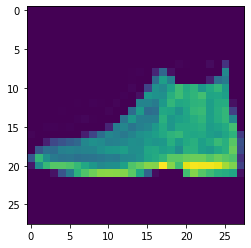

In [ ]:
# 10번 셀

# 샘플 결과 출력
print(X_test[0].shape)
# plt.imshow(X_test[0]) # TypeError: Invalid shape (28, 28, 1) for image data : 왜 에러가 났을까.shape.  답: imshow로 찍으려면 2차원이여야하지만 3차원이다.
# 구체적으로2차원 (28,28)로 바꿔줘야한다.
# imshow를 사용하려면 채널 정보가 있으면 안된다.

# imshow 함수는 채널 정보를 제거해야함
# (28,28,1) -> (28,28) : 
# 방법1 : np.reshape() -> 이것보다 쉬운방법이 방법2다
# 방법2 : squeeze
# 방버 3 : img = X_test[0].squeeze() 도 가능하다.스퀴즈 써서 채널정보 빼준다.
img = np.squeeze(X_test[0])
print(img.shape)
plt.imshow(img)

print('라벨 : ',Y_test[0]) # X_test[0]은 anckle boots이다. 정답이 라벨 9이라는 의미이다.
# 이제 기계가 뭐라고 예측했느지 확인해보자
pred = model.predict(X_test) # 
# print('CNN 예측 : ', pred[0]) # X_test[0]이 아니다
# 왜 예측값이 10개나 만들었을까? 답 : 라벨 각각의 확률을 의미한다. 이게 확률 10개다. 
# 예측값이 9.97445703e-01가 가장 크므로 라벨 9일 확률이 가장 크다는 의미이다. 따라서 맞았다.
# 이렇게 10개 다 주지 말고 9번째가 가장 커요라고 말해주는 명령어를 아는 사람 ? 답 : 
# max(pred[0])이 아니고 argmax이다. 코딩은 다음과 같이한다.
print('CNN 예측 : ', np.argmax(pred[0])) # 9를 반환하므로 10개 중 라벨 9가 가장크다고 말해주는 거다.
# 제일 큰게 몇번쨰에 있는지 알려주는 함수다.
# 낯선 것을 반복해서 익숙하게 만들어라

In [ ]:
# 합성곱 신경망을 이용한 이미지 인식